In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random

random.seed(10)

In [ ]:
!cp "/content/drive/My Drive/Histopathology data/converted.zip" "converted.zip"

In [ ]:
!unzip -q converted.zip

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('converted/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, test_files, train_classes, test_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['ADI' 'BACK' 'DEB' 'LYM' 'MUC' 'MUS' 'NORM' 'STR' 'TUM']


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 5 # We use a small batch size here for training
batch_size_test = 10 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('converted/', train_files, train_classes, 
                         transforms=image_transform)
test_dataset = Hist('converted/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: STR


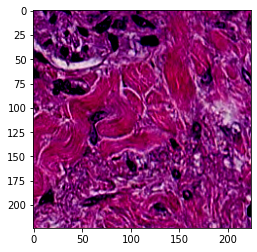

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import torch.nn as nn
import torch.nn.functional as F


class InitBlock(nn.Module):
    expansion = 2  
    
  
    def __init__(self, in_planes, cardinality=32, bottleneck_width=4, stride=1):
        super(InitBlock, self).__init__()
        group_width = cardinality * bottleneck_width
        self.convolution1 = nn.Conv2d(in_planes, group_width, kernel_size=1, bias=False)
        self.batchnormal1 = nn.BatchNorm2d(group_width)
        
        self.convolution2 = nn.Conv2d(group_width, group_width, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.batchnormal2 = nn.BatchNorm2d(group_width)
        self.convolution3 = nn.Conv2d(group_width, self.expansion*group_width, kernel_size=1, bias=False)
        self.batchnormal3 = nn.BatchNorm2d(self.expansion*group_width)

        self.shortblock = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*group_width:
            self.shortblock = nn.Sequential(
              nn.Conv2d(in_planes, self.expansion*group_width, kernel_size=1, stride=stride, bias=False),
              nn.BatchNorm2d(self.expansion*group_width)
          )

    def forward(self, x):
        y = F.relu(self.batchnormal1(self.convolution1(x)))
        y = F.relu(self.batchnormal2(self.convolution2(y)))
        y = self.batchnormal3(self.convolution3(y))
        y += self.shortblock(x)
        y = F.relu(y)
        return y


class ResNeXt(nn.Module):
    def __init__(self, input_channel, num_blocks, cardinality, bottleneck_width, n_classes):
        super(ResNeXt, self).__init__()
        self.cardinality = cardinality
        self.bottleneck_width = bottleneck_width
        self.planes = 64

        self.convolution1 = nn.Conv2d(input_channel, 64, kernel_size=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.l1 = self.create_layer(num_blocks[0], 1)
        self.l2 = self.create_layer(num_blocks[1], 2)
        self.l3 = self.create_layer(num_blocks[2], 2)
       
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(cardinality*bottleneck_width*8, n_classes)

    def create_layer(self, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(InitBlock(self.planes, self.cardinality, self.bottleneck_width, stride))
            self.planes = InitBlock.expansion * self.cardinality * self.bottleneck_width
        
        self.bottleneck_width *= 2
        return nn.Sequential(*layers)

    def forward(self, x):
        y = F.relu(self.batchnorm1(self.convolution1(x)))
        y = self.l1(y)
        y = self.l2(y)
        y = self.l3(y)
        
        y = self.pool(y)
        y = y.view(y.size(0), -1)
        y = self.linear(y)
        return y



def ResNeXt29_2x64d(input_channel, n_classes):
    return ResNeXt(input_channel=input_channel, num_blocks=[3,3,3], cardinality=2, bottleneck_width=64, n_classes=n_classes)


In [ ]:
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNeXt29_32x4d(input_channel=3, n_classes=9).to(device)
learning_rate = 0.0005
weight_decay = 0.001
for param in model.parameters():
    param.requires_grad = True
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(parameters, lr=learning_rate, weight_decay=weight_decay)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        # after fetching the data transfer the model to the 
        # required device, in this example the device is gpu
        # transfer to gpu can also be done by 
        # data, target = data.cuda(), target.cuda()
        data, target = data.to(device), target.to(device)  
        # compute the forward pass
        # it can also be achieved by model.forward(data)
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    
##define test function
def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  # data, target = data.cuda(), target.cuda()
        # since we dont need to backpropagate loss in testing,
        # we dont keep the gradient
        with torch.no_grad():
            # compute the forward pass
            # it can also be achieved by model.forward(data)
            output = model(data)
        # compute the loss function just for checking
        loss_this = F.cross_entropy(output, target) # sum up batch loss
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [ ]:
import os.path
from os import path

num_epoch = 30
train_loss=[]
test_loss=[]
accuracy_test=[]
acc=0
for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=test(model, device, test_loader)
    if acc<acct:
      if path.exists("ResNext9categoriesmodel.pth"):
        os.remove("ResNext9categoriesmodel.pth")

      torch.save(model.state_dict(), 'ResNext9categoriesmodel.pth')
      acc=acct
    train_loss.append(tl)
    test_loss.append(stl)
    accuracy_test.append(acct)

!cp ResNext9categoriesmodel.pth '/content/drive/My Drive/Histopathology data/'

train_l=str(train_loss)
test_l=str(test_loss)
accuracy_t=str(accuracy_test)

output_file = open('training_accuracy.txt', 'w')

for t in train_l:
    output_file.write(t)

output_file.close()


output_file = open('test_loss.txt', 'w')

for t in test_l:
    output_file.write(t)

output_file.close()

output_file = open('accuracy_test.txt', 'w')

for t in accuracy_t:
    output_file.write(t)

output_file.close()


1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 1.0185

Test: Average loss: 0.8117, Accuracy: 4034/5400 (74.70%)

2


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.7201

Test: Average loss: 0.6950, Accuracy: 4339/5400 (80.35%)

3


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.6101

Test: Average loss: 0.6524, Accuracy: 4511/5400 (83.54%)

4


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.5053

Test: Average loss: 0.9487, Accuracy: 4307/5400 (79.76%)

5


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.4383

Test: Average loss: 0.4806, Accuracy: 4617/5400 (85.50%)

6


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.3944

Test: Average loss: 0.4524, Accuracy: 4678/5400 (86.63%)

7


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.3537

Test: Average loss: 0.4482, Accuracy: 4667/5400 (86.43%)

8


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.3406

Test: Average loss: 0.3767, Accuracy: 4814/5400 (89.15%)

9


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.3236

Test: Average loss: 0.3621, Accuracy: 4908/5400 (90.89%)

10


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.3129

Test: Average loss: 0.3981, Accuracy: 4896/5400 (90.67%)

11


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2952

Test: Average loss: 0.4501, Accuracy: 4779/5400 (88.50%)

12


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2895

Test: Average loss: 0.5801, Accuracy: 4637/5400 (85.87%)

13


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2766

Test: Average loss: 0.3200, Accuracy: 4990/5400 (92.41%)

14


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2736

Test: Average loss: 0.4370, Accuracy: 4867/5400 (90.13%)

15


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2664

Test: Average loss: 0.4042, Accuracy: 4896/5400 (90.67%)

16


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2549

Test: Average loss: 0.2747, Accuracy: 5067/5400 (93.83%)

17


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2603

Test: Average loss: 0.4242, Accuracy: 4918/5400 (91.07%)

18


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2490

Test: Average loss: 0.7539, Accuracy: 4857/5400 (89.94%)

19


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2397

Test: Average loss: 2.2672, Accuracy: 4802/5400 (88.93%)

20


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2433

Test: Average loss: 0.2911, Accuracy: 4972/5400 (92.07%)

21


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2319

Test: Average loss: 0.2928, Accuracy: 5041/5400 (93.35%)

22


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2423

Test: Average loss: 1.2895, Accuracy: 4962/5400 (91.89%)

23


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2286

Test: Average loss: 0.5659, Accuracy: 4886/5400 (90.48%)

24


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2266

Test: Average loss: 0.2816, Accuracy: 5028/5400 (93.11%)

25


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2275

Test: Average loss: 0.6323, Accuracy: 4898/5400 (90.70%)

26


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2196

Test: Average loss: 0.5928, Accuracy: 4771/5400 (88.35%)

27


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2138

Test: Average loss: 0.4382, Accuracy: 4931/5400 (91.31%)

28


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2142

Test: Average loss: 0.4324, Accuracy: 4940/5400 (91.48%)

29


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2102

Test: Average loss: 0.7350, Accuracy: 4928/5400 (91.26%)

30


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2151

Test: Average loss: 0.3073, Accuracy: 5041/5400 (93.35%)



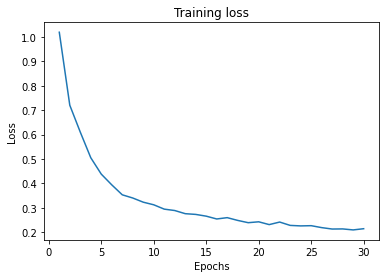

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,train_loss)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

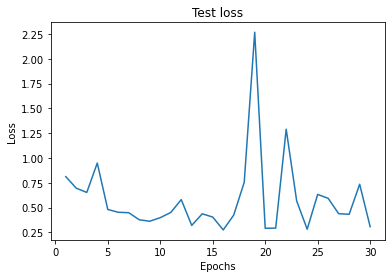

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,test_loss)
plt.title('Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

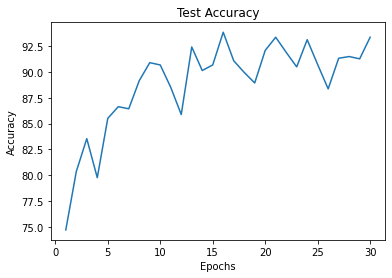

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,accuracy_test)
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()